In [1]:
import os

# Changes the notebook working directory on level up.
%cd ..

# Running main python script.
%run -i "src/main.py"

# Data set from main.py
data_set

/Users/Anne/Documents/UIS/DAT540/Project_Netflix/Project/dat540-netflix_catalogue


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,Unknown director,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,Unknown director,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,Unknown director,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...
...,...,...,...,...,...,...,...,...,...,...,...,...
6229,80000063,TV Show,Red vs. Blue,Unknown director,"Burnie Burns, Jason Saldaña, Gustavo Sorola, G...",United States,Unknown date_added,2015,NR,13 Seasons,"TV Action & Adventure, TV Comedies, TV Sci-Fi ...","This parody of first-person shooter games, mil..."
6230,70286564,TV Show,Maron,Unknown director,"Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh...",United States,Unknown date_added,2016,TV-MA,4 Seasons,TV Comedies,"Marc Maron stars as Marc Maron, who interviews..."
6231,80116008,Movie,Little Baby Bum: Nursery Rhyme Friends,Unknown director,Unknown cast,Unknown country,Unknown date_added,2016,Unknown rating,60 min,Movies,Nursery rhymes and original music for children...
6232,70281022,TV Show,A Young Doctor's Notebook and Other Stories,Unknown director,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...",United Kingdom,Unknown date_added,2013,TV-MA,2 Seasons,"British TV Shows, TV Comedies, TV Dramas","Set during the Russian Revolution, this comic ..."


In [2]:
import datetime as dt
from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk

In [3]:
# function for text cleaning 
def clean_text(text):
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text



In [4]:
# create new data set with only type = Movie
new_set = data_set.copy()

# Split genres into list
new_set['genre'] = new_set['listed_in'].apply(lambda x: x.split(', '))

In [5]:
# Clean each description and title using clean_text function
new_set['clean_desc'] = new_set['description'].apply(lambda x: clean_text(x))
new_set['clean_title'] = new_set['title'].apply(lambda x: clean_text(x))
#new_set.drop('clean_disc', axis=1, inplace=True)

# List of 8 genres with the least no. of movies
#rare_genres = data_set[data_set.type=="Movie"].listed_in.str.split(', ').explode().value_counts().index[-8:]

# Rename the 8 rare genres above with "Other"
#new_set['genre'] = new_set.genre.apply(lambda x: ["Other" if np.isin(y, rare_genres) else y for y in x])

#Remove International Movies genre as this is a genre that can not be defined from title or plot summary
#new_set['genre'] = (new_set.genre.map(set)-{'International Movies'}).map(list)

# add title to description
# new_set['title_description'] = new_set['clean_title'] + str(" ") + new_set['clean_desc']

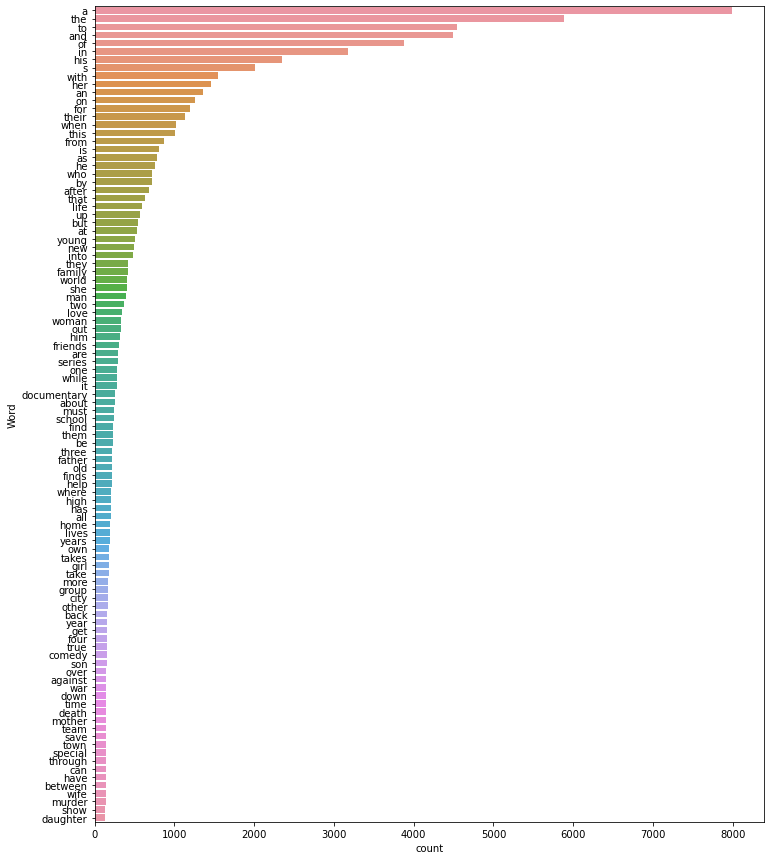

In [6]:
def freq_words(text, terms = 30): 
  # Create word list from all words in title and description in pandas series
  words = text.str.split(expand=True).stack()
  
  # selecting top n most frequent words in order
  d = words.value_counts().index[:terms]
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.countplot(y=words, order=d)
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(new_set['clean_desc'], 100)

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/Anne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

new_set['clean_desc'] = new_set['clean_desc'].apply(lambda x: remove_stopwords(x))

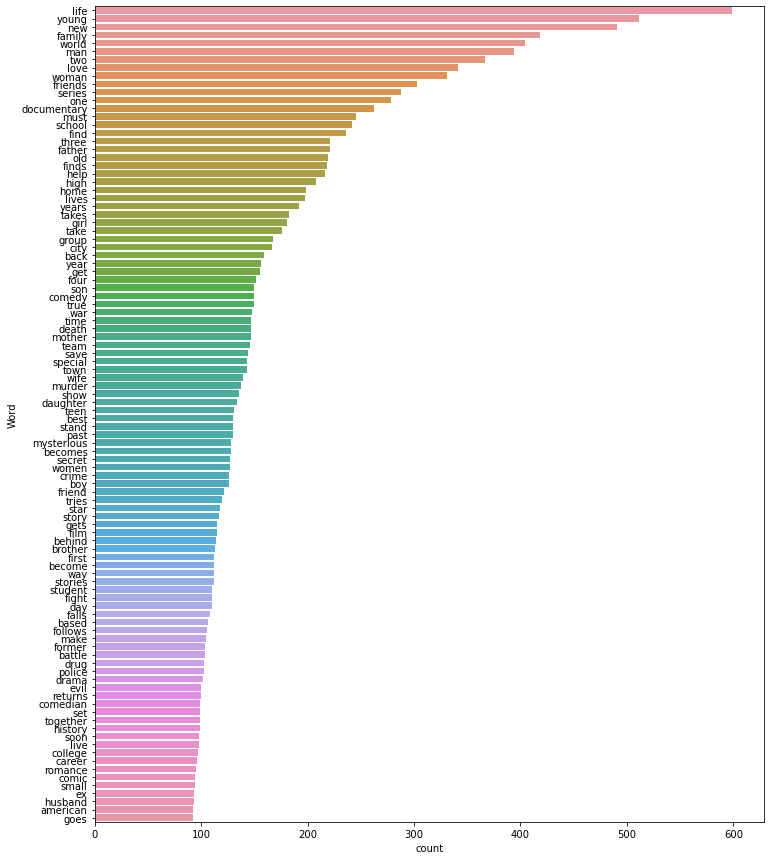

In [9]:
# Check most frequent words after removing stopwords
freq_words(new_set['clean_desc'], 100)

Since we have a multi label data set (one movie can have multiple genres), we need to transform the target variable (genres) into separate target variables.
We use the Binary Relevance approach to assign the genre to the unique target label.

The sklearn MultiLabelBinarizer allows us to encode multiple labels per instance. This transforms the target into an array of binary values where 1 and 0 at different locations in the arrays represents the genres.
Binary array indicating the presence of a class label.
One new target variable per unique genre (19)

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# Fit the label sets binarizer and transform target variable
y = mlb.fit_transform(new_set['genre'])


In [11]:
# The binary classes:
print(mlb.classes_)
# We see that the genres are represented as a binary vector with values
# A 1 represents that this row have the following grenre
print(y[3]) # Example
# By taking the inverse transferm we can see that what genre the bianry represents
print(mlb.inverse_transform(y)[3])

['Action & Adventure' 'Anime Features' 'Anime Series' 'British TV Shows'
 'Children & Family Movies' 'Classic & Cult TV' 'Classic Movies'
 'Comedies' 'Crime TV Shows' 'Cult Movies' 'Documentaries' 'Docuseries'
 'Dramas' 'Faith & Spirituality' 'Horror Movies' 'Independent Movies'
 'International Movies' 'International TV Shows' "Kids' TV"
 'Korean TV Shows' 'LGBTQ Movies' 'Movies' 'Music & Musicals' 'Reality TV'
 'Romantic Movies' 'Romantic TV Shows' 'Sci-Fi & Fantasy'
 'Science & Nature TV' 'Spanish-Language TV Shows' 'Sports Movies'
 'Stand-Up Comedy' 'Stand-Up Comedy & Talk Shows' 'TV Action & Adventure'
 'TV Comedies' 'TV Dramas' 'TV Horror' 'TV Mysteries'
 'TV Sci-Fi & Fantasy' 'TV Shows' 'TV Thrillers' 'Teen TV Shows'
 'Thrillers']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]
("Kids' TV",)


TF-IDF stands for Term Frequency — Inverse Document Frequency and is a statistic that aims to better define how important a word is for a document, while also taking into account the relation to other documents from the same corpus. <br>
TfidVectorizer transforms text to feature vectors ( that can be used as input to estimator).
The data set is quite short, and 100th most frequent word is only used about 70 times, and the 1000th word is used about 10 times, and have therefore not used more than 1000 most frequent words as features.
max_df removes words with frequency higher than 80%

Split data set into train and validation sets for training and evaluating the model's performance. Use a 80-20 split where 80% of the data samples are in the train set and the rest are in the validation set. <br>
Setting of random_state ensures same results every time

In [44]:
# Import TfidVectorizer and train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Initialize TfidVectorizer with 1000 most frequent words
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=5000)

# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(new_set['clean_desc'], y, test_size=0.2, random_state=9)

# create TF-IDF features
# fit_transform(): Learn vocabulary and idf from training set, return document-term matrix
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain) 
xval_tfidf = tfidf_vectorizer.transform(xval)

F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account.

OneVsRestClassifier is the most commonly used strategy for multiclass classification. 

https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html?highlight=onevsrestclassifier&fbclid=IwAR3Hm-791LbLCwBVkIUdSFo3hUBiWWUdWQ4AyLYj89uEWSjMuKXR_52HKJY#sklearn.multiclass.OneVsRestClassifier

In [45]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix

In [46]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [47]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression())

In [48]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [49]:
#Check prediciton 
print(y_pred[1])

# Inverse transform to get genres:
print(mlb.inverse_transform(y_pred)[1])


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]
()


In [50]:
# Check classification report with precision score, recall score and f1 score.
report = classification_report(yval, y_pred, output_dict=True)
class_df = pd.DataFrame(report).transpose()
gen_list = np.append(mlb.classes_, ["","","",""])
class_df['genre'] = gen_list
class_df

,precision,recall,f1-score,support,genre
0,0.000000,0.000000,0.000000,122.0,Action & Adventure
1,0.000000,0.000000,0.000000,8.0,Anime Features
2,0.000000,0.000000,0.000000,24.0,Anime Series
3,0.000000,0.000000,0.000000,42.0,British TV Shows
4,0.000000,0.000000,0.000000,80.0,Children & Family Movies
5,0.000000,0.000000,0.000000,5.0,Classic & Cult TV
6,0.000000,0.000000,0.000000,24.0,Classic Movies
7,0.333333,0.008333,0.016260,240.0,Comedies
8,0.500000,0.012500,0.024390,80.0,Crime TV Shows
9,0.000000,0.000000,0.000000,15.0,Cult Movies


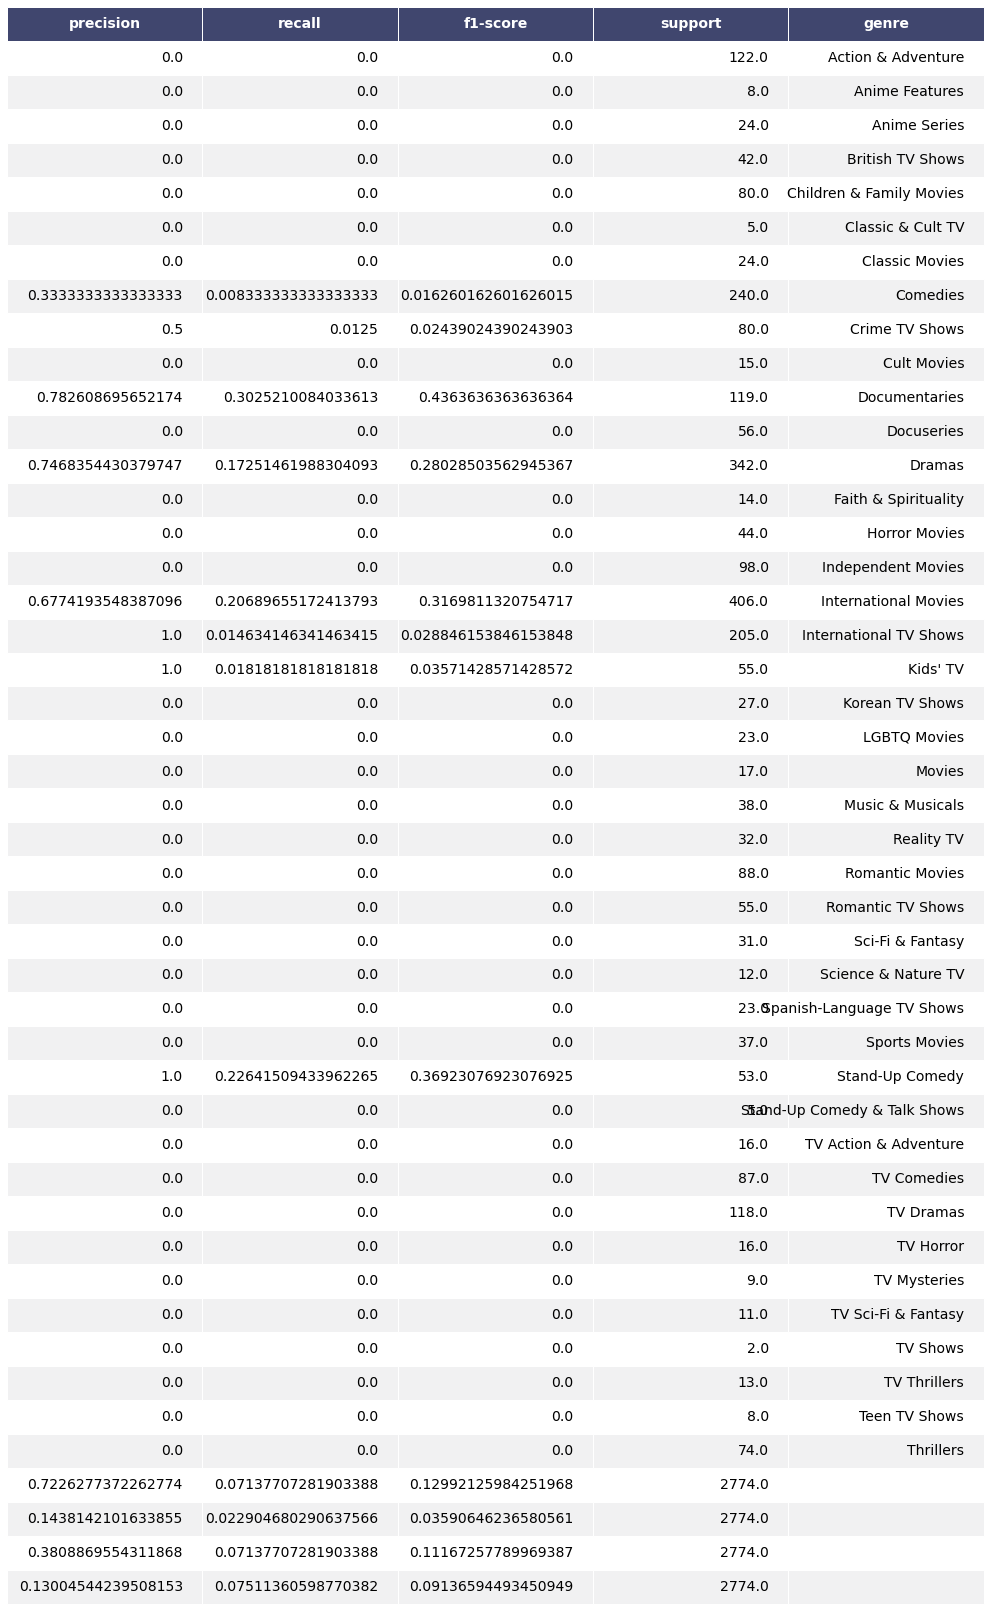

In [65]:
def render_mpl_table(data, col_width=5.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(class_df, header_columns=0, col_width=3.5)
fig.savefig("pre_genre_clean.png")

In [60]:
import plotly.figure_factory as ff
fig =  ff.create_table(class_df)
fig.update_layout(
    autosize=False,
    width=500,
    height=200,
)
fig.write_image("table_plotly.png", scale=2)
fig.show()

ModuleNotFoundError: No module named 'plotly'

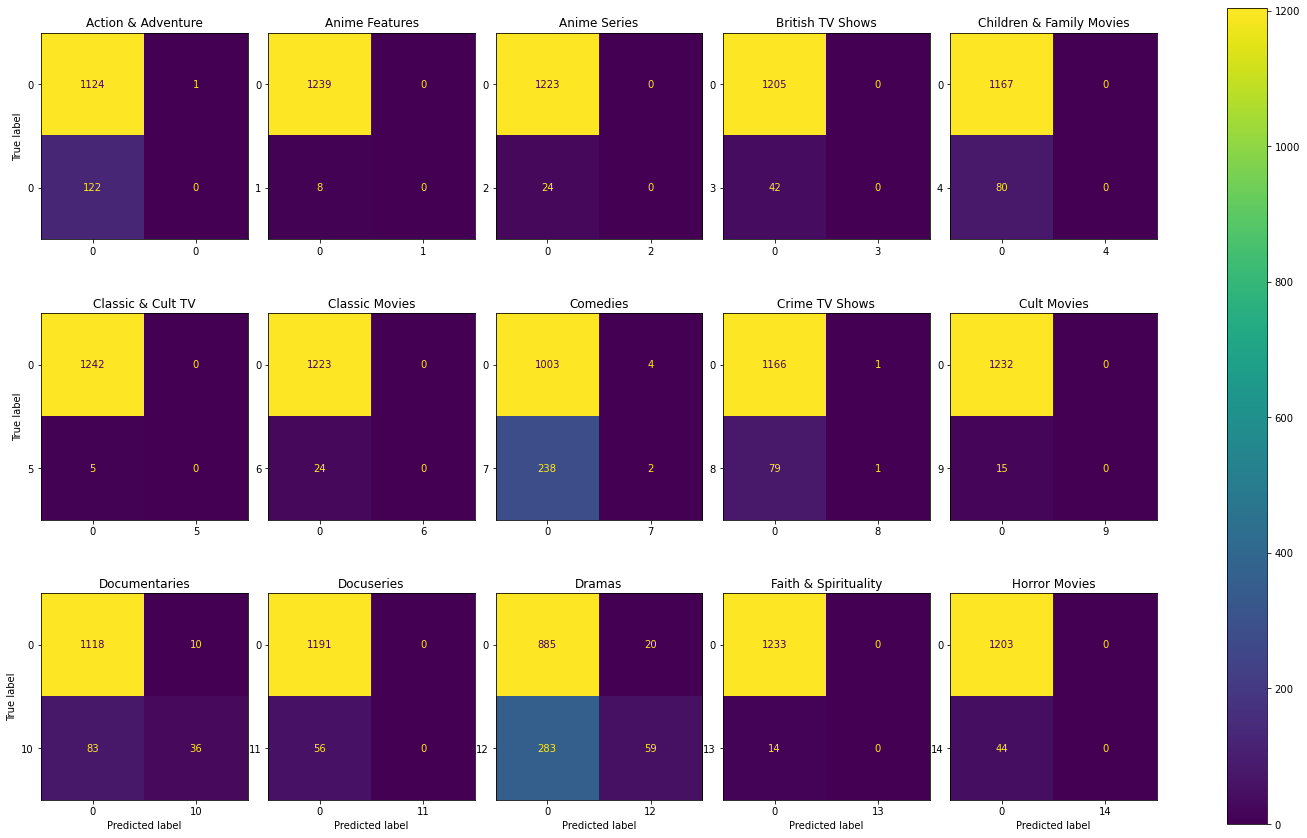

In [51]:
f, axes = plt.subplots(3, 5, figsize=(25, 15))
axes = axes.ravel()
for i in range(15):
    disp = ConfusionMatrixDisplay(confusion_matrix(yval[:, i],
                                                   y_pred[:, i]),
                                  display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'{mlb.classes_[i]}')
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [52]:
precision_score(yval, y_pred, average="micro")

0.7226277372262774

In [53]:
# evaluate performance
f1_score(yval, y_pred, average="micro")

0.12992125984251968

In [22]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)

In [23]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [24]:
# evaluate performance
f1_score(yval, y_pred_new, average="micro")

0.3551660516605166

In [25]:
def infer_tags(q):
    #q = clean_text(q)
    #q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return mlb.inverse_transform(q_pred)

In [26]:
for i in range(50): 
  k = xval.sample(1).index[0] 
  print("Movie: ", new_set['title'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ",new_set['genre'][k], "\n")


Movie:  Hurricane Bianca 
Predicted genre:  [()]
Actual genre:  ['Comedies', 'Independent Movies', 'LGBTQ Movies'] 

Movie:  Saeed Mirza: The Leftist Sufi 
Predicted genre:  [('Documentaries',)]
Actual genre:  ['Documentaries', 'International Movies'] 

Movie:  Losing Sight of Shore 
Predicted genre:  [('Documentaries',)]
Actual genre:  ['Documentaries', 'Sports Movies'] 

Movie:  Monster High: Freaky Fusion 
Predicted genre:  [()]
Actual genre:  ['Children & Family Movies'] 

Movie:  The Wedding Party 
Predicted genre:  [()]
Actual genre:  ['Comedies', 'Dramas', 'International Movies'] 

Movie:  The Trap 
Predicted genre:  [()]
Actual genre:  ['Comedies'] 

Movie:  Tig 
Predicted genre:  [('Stand-Up Comedy',)]
Actual genre:  ['Documentaries', 'Stand-Up Comedy'] 

Movie:  Monster High: Why Do Ghouls Fall in Love? 
Predicted genre:  [()]
Actual genre:  ['Children & Family Movies'] 

Movie:  Sisters 
Predicted genre:  [()]
Actual genre:  ['International TV Shows', 'TV Comedies', 'TV Dram

In [27]:
k=xval.sample(1).index[0]
print(k)
q=xval[k]
print(q)
#q = clean_text(q)
#print(q)
#q = remove_stopwords(q)
#print(q)
q_vec = tfidf_vectorizer.transform([q])
print(q_vec)
q_pred = clf.predict(q_vec)
print(q_pred)
cat = mlb.inverse_transform(q_pred)
print(cat)

4305
head lucrative family business passes away leaves clan extreme odds
  (0, 633)	0.4347287331621343
  (0, 517)	0.37139244050641407
  (0, 410)	0.38962994924032307
  (0, 312)	0.23981503188520398
  (0, 302)	0.44287232185061093
  (0, 112)	0.3537682888558016
  (0, 58)	0.3774492564219784
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0]]
[()]


array(['Action & Adventure', 'Anime Features', 'Children & Family Movies',
       'Classic Movies', 'Comedies', 'Cult Movies', 'Documentaries',
       'Dramas', 'Faith & Spirituality', 'Horror Movies',
       'Independent Movies', 'LGBTQ Movies', 'Movies', 'Music & Musicals',
       'Romantic Movies', 'Sci-Fi & Fantasy', 'Sports Movies',
       'Stand-Up Comedy', 'Thrillers'], dtype=object)

(4265, 16)